In [39]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/srv/conda/envs/notebook/share/gdal" # need to specify to make gdal work
os.environ["PROJ_LIB"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
os.environ["PROJ_DATA"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
import numpy as np
import pandas as pd
from matplotlib import cm 
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl
from datetime import datetime
from dateutil.relativedelta import relativedelta
from rasterio import warp

from utils.nsidc import download_is2
from utils.readers import read_atl06
from utils.S2 import plotS2cloudfree, add_inset
try:
    from ed.edcreds import getedcreds
except:
    print('No earthdata credentials found.')
    print('To set up, rename the folder "ed_example" to "ed".')
    print('Then, add your earthdata credentials to "ed/edcreds.py".')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Show area of interest on a map

In [2]:
# I just drew these randomly on a map...
shape = 'data/shapefiles/gilac-grounding.geojson'
shape_buffer = 'data/shapefiles/kreitzer-region-large.geojson'

gdf = gpd.read_file(shape)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_coords = list(zip(lats,lons))
shape_bounds = [[np.min(lats),np.min(lons)], [np.max(lats),np.max(lons)]]

gdf = gpd.read_file(shape_buffer)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_buffer_coords = list(zip(lats,lons))

m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=7)
m.fit_bounds(shape_bounds)
polygon = Polygon(locations=shape_buffer_coords, color="red", fill_color="red", name='polygon_buffered')
m.add_layer(polygon)
polygon2 = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon2)
m.add_control(LayersControl())
m

Map(center=[-70.46223534840162, 72.12093417598801], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Download the ATL06 ICESat-2 Data

In [3]:
re_download_data = False

short_name = 'ATL06'
start_download_date = '2019-04-01' # this is when ICESat-2 started RGT pointing
version = 6
output_dir = 'data/IS2/v%03i' % version
increment_months = 6

# this is to get the earthdata credits into the notebook without pushing them to github
# can also specify them directly here like below
# uid = 'insert_your_earthdata_user_id_here'
# pwd = 'insert_your_earthdata_password_here'
uid, pwd, email = getedcreds()

# to set up the getedcreds() function:
# - create a folder called "ed"
# - in this folder, create an empty file called "__init__.py"
# - in this folder, creat a file called "edcreds.py", with the following function:
#   def getedcreds(): return '<your_earthdata_user_id>', '<your_earthdata_password>', '<your_email_address>'
# - if you push to github, make sure to include the folder ed/ in your .gitignore

if re_download_data:
    dateformat = '%Y-%m-%d'
    end_download_datetime = datetime.strptime(start_download_date, dateformat)
    while end_download_datetime < datetime.now():
        start_download_datetime = end_download_datetime + relativedelta(days=1)
        end_download_datetime = start_download_datetime + relativedelta(months=increment_months)
        start_date = datetime.strftime(start_download_datetime, dateformat)
        end_date = datetime.strftime(end_download_datetime, dateformat)
        print('\n______________________________________________________________________\n')
        print('downloading data: %s  --->  %s' % (start_date, end_date))
        download_is2(short_name=short_name, 
                 start_date=start_date, 
                 end_date=end_date, 
                 uid=uid, 
                 pwd=pwd, 
                 shape=shape, 
                 output_dir=output_dir,
                 version=version)

### Get a list of all the ATL06 data files over this region

In [4]:
search_for = 'ATL06_'
search_in = output_dir + '/'
filelist = [search_in+f for f in os.listdir(search_in) \
            if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
filelist.sort()
print('There are %i files.' % len(filelist))

There are 124 files.


### Just pick the first file, and plot the ground tracks on the map

In [5]:
file = filelist[0]
ancillary, dfs = read_atl06(file, verbose=False)
for gtx in dfs.keys():
    dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]

### Some helpful ancillary data for an example ICESat-2 track

In [6]:
ancillary

{'granule_id': 'ATL06_20190412134044_02180310_006_02.h5',
 'date': '2019-04-12',
 'atlas_sdp_gps_epoch': 1198800018.0,
 'rgt': 218,
 'cycle_number': 3,
 'sc_orient': 'backward',
 'gtx_beam_dict': {'gt1l': 1,
  'gt1r': 2,
  'gt2l': 3,
  'gt2r': 4,
  'gt3l': 5,
  'gt3r': 6},
 'gtx_strength_dict': {'gt1l': 'strong',
  'gt1r': 'weak',
  'gt2l': 'strong',
  'gt2r': 'weak',
  'gt3l': 'strong',
  'gt3r': 'weak'}}

### an example dataframe with ATL06 data

In [7]:
print(dfs.keys())

dict_keys(['gt2r', 'gt3l', 'gt3r'])


In [8]:
dfs['gt3l'].head()

,delta_time,lat,lon,xatc,yatc,dh_fit_dy,h,geoid_h,qual_summary
0,4.031197e+07,-70.553738,72.320934,2.794190e+07,-3326.633057,0.001290,96.710709,15.556290,0
1,4.031197e+07,-70.553915,72.320869,2.794192e+07,-3326.497070,0.000882,96.651939,15.555749,0
2,4.031197e+07,-70.554093,72.320804,2.794194e+07,-3326.380371,0.000695,96.632774,15.555216,0
3,4.031197e+07,-70.554270,72.320737,2.794196e+07,-3326.321777,0.000818,96.642067,15.554694,0
4,4.031197e+07,-70.554447,72.320670,2.794198e+07,-3326.305420,0.000309,96.628006,15.554148,0


### show a few tracks on a map to get an idea of coverage

In [9]:
m=Map(basemap=basemaps.Esri.WorldImagery,
      center=list(np.mean(np.array(shape_coords), axis=0)),
      zoom=9)
m.fit_bounds(shape_bounds)

polygon = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon)

# plot the first 15 tracks
nfiles = 15
filelist.sort()
for file in filelist[:nfiles]:
    ancillary, dfs = read_atl06(file, verbose=False)
    for gtx in dfs.keys():
        dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]
        dfs[gtx].lat, dfs[gtx].lon
        coords = list(zip(dfs[gtx].lat, dfs[gtx].lon))
        weight = 2 if ancillary['gtx_strength_dict'][gtx] == 'strong' else 1
        name = 'track %d-%s' % (ancillary['rgt'], gtx)
        line = Polyline(locations=coords,color="red",weight=weight,fill=False, name=name, opacity=0.25)
        m.add_layer(line)

m.add_control(LayersControl())
m

Map(center=[-70.6667519880621, 71.95380449994946], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## get a dataframe with basic file info

In [10]:
df_files = pd.DataFrame({'filename': filelist})
df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.find('ATL06_'):], axis=1)
df_files['date'] = df_files.apply(lambda x: x.granule_id[6:10]+'-'+x.granule_id[10:12]+'-'+x.granule_id[12:14], axis=1)
df_files['track'] = df_files.apply(lambda x: int(x.granule_id[21:25]), axis=1)
df_files.head()

,filename,granule_id,date,track
0,data/IS2/v006/processed_ATL06_20190412134044_0...,ATL06_20190412134044_02180310_006_02.h5,2019-04-12,218
1,data/IS2/v006/processed_ATL06_20190413022827_0...,ATL06_20190413022827_02260312_006_02.h5,2019-04-13,226
2,data/IS2/v006/processed_ATL06_20190416133222_0...,ATL06_20190416133222_02790310_006_02.h5,2019-04-16,279
3,data/IS2/v006/processed_ATL06_20190515120821_0...,ATL06_20190515120821_07210310_006_02.h5,2019-05-15,721
4,data/IS2/v006/processed_ATL06_20190516005604_0...,ATL06_20190516005604_07290312_006_02.h5,2019-05-16,729


## pick a track and GTX and show some repeat tracks

In [68]:
track = 721
gtx = 'gt3l'
# track = 226
# gtx = 'gt3l'
df_track = df_files[df_files.track == track].sort_values(by='date').reset_index(drop=True)
nfiles = len(df_track)
df_track.head()

,filename,granule_id,date,track
0,data/IS2/v006/processed_ATL06_20190515120821_0...,ATL06_20190515120821_07210310_006_02.h5,2019-05-15,721
1,data/IS2/v006/processed_ATL06_20191113032759_0...,ATL06_20191113032759_07210510_006_01.h5,2019-11-13,721
2,data/IS2/v006/processed_ATL06_20200211230741_0...,ATL06_20200211230741_07210610_006_01.h5,2020-02-11,721
3,data/IS2/v006/processed_ATL06_20200512184732_0...,ATL06_20200512184732_07210710_006_01.h5,2020-05-12,721
4,data/IS2/v006/processed_ATL06_20200811142717_0...,ATL06_20200811142717_07210810_006_01.h5,2020-08-11,721


### show the tracks to make sure there are no outliers

In [69]:
m=Map(basemap=basemaps.Esri.WorldImagery,
      center=list(np.mean(np.array(shape_coords), axis=0)),
      zoom=9)
m.fit_bounds(shape_bounds)

polygon = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon)

for i in range(nfiles):
    filedata = df_track.iloc[i]
    ancillary, dfs = read_atl06(filedata.filename, verbose=False)
    if gtx in dfs.keys():
        df = dfs[gtx]
        df = df[df.qual_summary == 0].copy()
        coords = list(zip(df.lat, df.lon))
        weight = 2 if ancillary['gtx_strength_dict'][gtx] == 'strong' else 1
        name = '%s, track %d-%s' % (ancillary['date'], ancillary['rgt'], gtx)
        line = Polyline(locations=coords,color="red",weight=weight,fill=False, name=name, opacity=0.1)
        m.add_layer(line)

m.add_control(LayersControl())
m

Map(center=[-70.6667519880621, 71.95380449994946], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### plot elevations

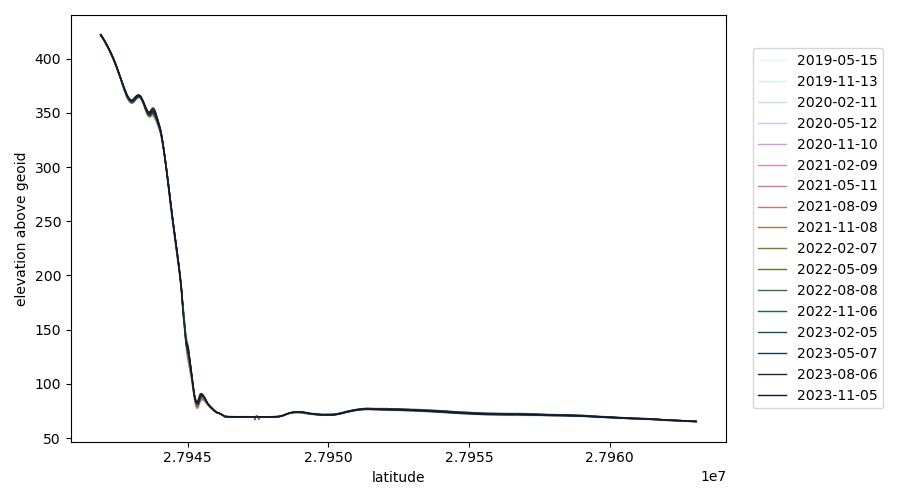

In [70]:
df_repeat = df_track.copy()
nfiles = len(df_repeat)

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
handles = []
dfsgtx = []

colors = cm.cubehelix_r(np.linspace(0.05,0.9,nfiles))
for i in range(nfiles):
    filedata = df_repeat.iloc[i]
    ancillary, dfs = read_atl06(filedata.filename, verbose=False)
    if gtx in dfs.keys():
        df = dfs[gtx]
        df.loc[df.qual_summary != 0,'h'] = np.nan
        df['h_geoid_corrected'] = df.h - df.geoid_h
        df.loc[np.abs(df.h_geoid_corrected) > 1e4,'h_geoid_corrected'] = np.nan
        line, = ax.plot(df.xatc, df.h_geoid_corrected,lw=1, color=tuple(colors[i,:]), label=ancillary['date'])
        # scatt = ax.scatter(0, 0 , s=10, alpha=1, color=tuple(colors[i,:]), label=ancillary['date'])
        df['date'] = ancillary['date']
        handles.append(line)
        dfsgtx.append(df)
plt.legend(handles=handles, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=10, ncols=1)
dfs_all = pd.concat(dfsgtx)
# ax.set_xlim((np.nanmin(dfs_all.lat), np.nanmax(dfs_all.lat)))
# ax.set_ylim((np.nanmin(dfs_all.h_geoid_corrected), np.nanmax(dfs_all.h_geoid_corrected)))
ax.set_xlabel('latitude')
ax.set_ylabel('elevation above geoid')
fig.tight_layout()

Looking for Sentinel-2 images from 2018-12-26T00:00:00 to 2019-01-15T00:00:00 --> there are 6 cloud-free images.
Looking for Sentinel-2 images from 2018-12-16T00:00:00 to 2019-01-25T00:00:00 --> there are 12 cloud-free images.
--> Closest cloud-free Sentinel-2 image:
    - product_id: S2B_MSIL2A_20190102T041719_N0211_R061_T42DWG_20190102T073517
    - time difference: -3 days, 4:18:29
    - mean cloud probability: 1.0
--> Downloaded the 8-bit RGB image as data/imagery/Gillock-Kreitzer_track721_gt3l.tif.


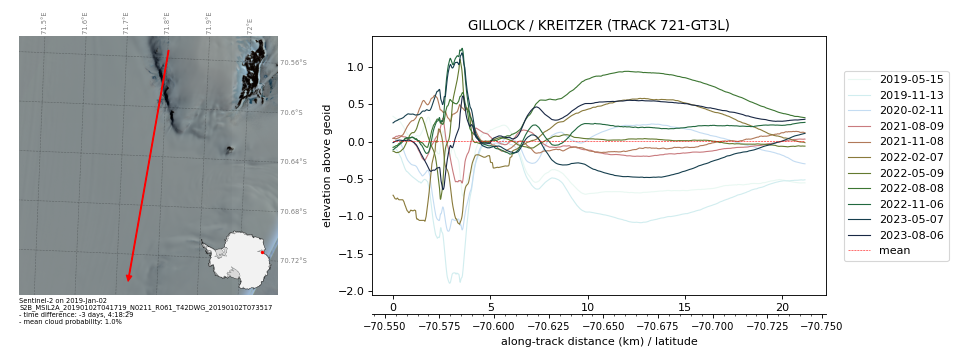

In [71]:
region = 'Gillock / Kreitzer'
dfs_all.xatc -= dfs_all.xatc.min()
x_interp = np.arange(0, dfs_all.xatc.max(), 10)
dates = np.unique(dfs_all.date)
ndates = len(dates)
colors = cm.cubehelix_r(np.linspace(0.05,0.9,ndates))

# get the median across-track dist
yatcvals_interp = []
dhdy_interp = []
h_vals_interp = []
lat_interp = []
lon_interp = []
for i, date in enumerate(dates):
    thisdf = dfs_all[dfs_all.date == date]
    thisdf.loc[np.abs(thisdf.yatc)>10000, 'yatc'] = np.nan
    thisdf.loc[np.abs(thisdf.dh_fit_dy)>1, 'dh_fit_dy'] = np.nan
    yatcvals_interp.append(np.interp(x_interp, thisdf.xatc, thisdf.yatc))
    dhdy_interp.append(np.interp(x_interp, thisdf.xatc, thisdf.dh_fit_dy))
    h_vals_interp.append(np.interp(x_interp, thisdf.xatc, thisdf.h_geoid_corrected))
    lat_interp.append(np.interp(x_interp, thisdf.xatc, thisdf.lat))
    lon_interp.append(np.interp(x_interp, thisdf.xatc, thisdf.lon))

yatcvals_interp = np.array(yatcvals_interp)
dhdy_interp = np.array(dhdy_interp)
h_vals_interp = np.array(h_vals_interp)
lat_interp = np.array(lat_interp)
lon_interp = np.array(lon_interp)

yatcmid = np.array(yatcvals_interp)
yatc25 = np.nanpercentile(yatcmid,25, axis=0)
yatc75 = np.nanpercentile(yatcmid,75, axis=0)
yatcmid[(yatcmid <= yatc25) |  (yatcmid >= yatc75)] = np.nan
mean_yatc = np.array(pd.Series(np.nanmean(yatcmid,axis=0)).rolling(center=True,min_periods=1,window=1000).mean())#.reshape(1,-1)
offtracky = yatcvals_interp - mean_yatc
h_vals_slopecorr = h_vals_interp - offtracky * dhdy_interp
to_discard = np.abs(offtracky) > 20
h_vals_slopecorr[to_discard] = np.nan
lat_interp[to_discard] = np.nan
lon_interp[to_discard] = np.nan

hmid = h_vals_slopecorr.copy()
# h25 = np.nanpercentile(hmid, 25, axis=0)
# h75 = np.nanpercentile(hmid, 75, axis=0)
# hmid[(hmid <= h25) |  (hmid >= h75)] = np.nan
# np.sum(np.isnan(hmid),axis=0)
mean_h = np.nanmean(hmid, axis=0)

fig = plt.figure(figsize=[12, 4.5], dpi=80)
gs = fig.add_gridspec(ncols=5, nrows=1)
axs= [] 
axs.append(fig.add_subplot(gs[0, :2]))
axs.append(fig.add_subplot(gs[0, 2:]))
filename_base = ('%s_track%s_%s' % (region,track,gtx)).replace(' ','').replace('/','-')

ax = axs[1]
handles = []
for i, date in enumerate(dates):
    hplot = pd.Series(h_vals_slopecorr[i,:] - mean_h).rolling(center=True,min_periods=1,window=100).mean()
    if np.sum(np.isnan(hplot)) / len(hplot) < 0.1:
        line, = ax.plot(x_interp/1000, hplot, lw=1, color=tuple(colors[i,:]), label=date)
        handles.append(line)

meanline, = ax.plot(x_interp/1000, 0*mean_h, 'r--', lw=0.5, label='mean')
handles.append(meanline)

ax.legend(handles=handles, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=10, ncols=1)
ax.set_ylabel('elevation above geoid')
ax.set_title(('%s (track %s-%s)' % (region, track, gtx)).upper())

_lat = lats
_xatc = x_interp/1000
def lat2xatc(l):
    return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
def xatc2lat(x):
    return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
secax = ax.secondary_xaxis(-0.075, functions=(xatc2lat, lat2xatc))
secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
secax.set_xlabel('along-track distance (km) / latitude', fontsize=10)
secax.tick_params(axis='both', which='major', labelsize=9)
secax.ticklabel_format(useOffset=False, style='plain')

ax = axs[0]
timeS2 = '2019-01-05T00:00:00Z'
imagery_filename = 'data/imagery/%s.tif'%filename_base
lons = np.nanmedian(lon_interp,axis=0)
lats = np.nanmedian(lat_interp,axis=0)
buff = np.max(x_interp)/2*1.1
myImage = plotS2cloudfree(lon=np.mean(lons), lat=np.mean(lats), date_time=timeS2, buffer_m=buff, max_cloud_prob=5, gamma_value=0.7, 
                imagery_filename=imagery_filename, ax=ax, download_imagery=True)
add_inset(ax, lat, lon, inset='antarctica', loc=[0.69, 0.01], width=0.3, height=0.25)
ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=lons, ys=lats)
ax.annotate('', xy=(ximg[-1], yimg[-1]), xytext=(ximg[0], yimg[0]),
             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
ax.plot(ximg, yimg, 'r-', lw=0.5, zorder=500)

fig.tight_layout()
fig.savefig('%s.jpg'%filename_base, dpi=300)